In [1]:
from utils_data_handling import *
from utils_preprocessing import *

# Sapienza dataset


The array has a shape of:  (6, 6000000)


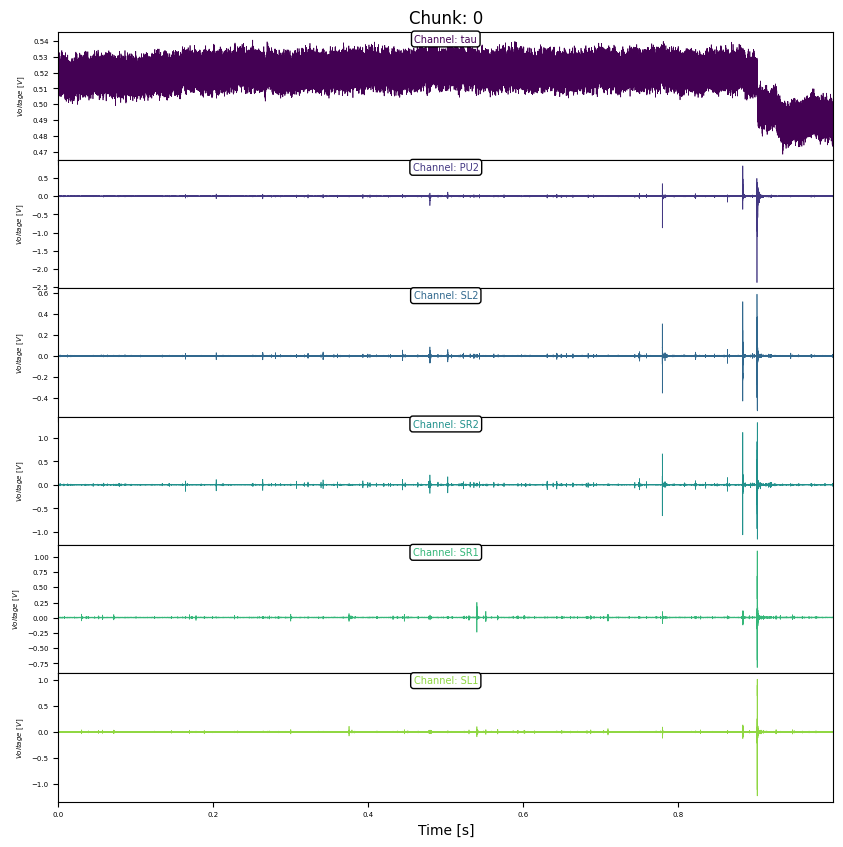

In [2]:
input_folder = ".../Desktop/Progetto_Chris/Coding_Chris/Data_Chris/s0133_all/"
channels_names=['tau','PU2','SL2','SR2','SR1','SL1']
list_channels=[1,2,3,4,5,6] # list channels you want to use

float_type='float32'
chunk=0   # IMPOSTARLO A 0 QUANDO AVREMO TUTTI I CHUNK (DA 0 A 200 AD ESEMPIO), QUESTO è IL CHUNK DI PARTENZA
fs=6e6      # sample rate
f_chunk=6e6 # numb of samples for each chunk (i.e. 1 chunk = 1 sec)

AE_array=create_data_chunk(input_folder,list_channels,chunk,float_type=float_type) # chank zero, 6 channels
print('The array has a shape of: ',AE_array.shape)
plot_chunk(fs,AE_array,channels_names,chunkname=chunk)

In [3]:
chosen_channel = 2
number_of_chunks = 200
T=np.arange(f_chunk)

In [4]:
acoustic_data_raw, chosen_chunks = combine_chunks_single_channel(input_folder, chunk, chosen_channel, number_of_chunks, T, float_type=float_type)


In [5]:
fs_red=1000 # 1KHz
shear_stress = reduce_stress_from_acoustic(input_folder, chunk, fs, fs_red, step=number_of_chunks,f_chunk=f_chunk,float_type=float_type)

Max folder number: 199
The last chunk is the number:  199
Processing chunk: 0


In [6]:
def moving_average(ST, window_size):
  """
  preservare la dimensione originale dell’array mentre applichi lo smoothing
  """
  return np.convolve(ST, np.ones(window_size)/window_size, mode='same')

In [7]:
denoised_shear_stress=moving_average(shear_stress,50)

In [8]:
step_size = 30  # Numero di punti tra i valori utilizzati nel calcolo del rapporto incrementale
                # Lo step size non influisce solo sulla precisione della derivata, ma anche sui significant_points calcolati
                # scegliere uno step_size troppo piccolo porta ad avere più significant_points per lo stesso stress drop

# Calcola la prima derivata usando un passo maggiore
first_derivative = np.diff(denoised_shear_stress[::step_size]) / (1 * step_size) # Nel rapporto incrementale classico il denominatore è 1 se i dati sono equispaziati
                                                                      # qui moltiplichiamo per step_size perché non stiamo calcolando punto per punto, ma su una finestra
#SI PUò ANCHE FARE DIRETTAMENTE CON LA DERIVATA PRIMA

# Calcola la seconda derivata dal risultato della prima derivata
second_derivative = np.diff(first_derivative) / step_size

# Soglia per identificare cambiamenti significativi
threshold = 1.5 * np.std(second_derivative)
significant_points = np.where(np.abs(second_derivative) > threshold)[0] # vive nello spazio first_derivative.shape 

In [10]:
threshold = 5

significant_points = unify_close_indices(significant_points, threshold)
print("Unified Indices:", significant_points)

Unified Indices: [   0   28  185  309  358  463  510  629  789 1002 1181 1340 1486 1657
 1815 1975 2138 2282 2453 2623 2798 2957 3141 3293 3484 3649 3817 3976
 4152 4334 4497 4669 4816 4974 5113 5264 5414 5586 5758 5900 6081 6258
 6436 6618 6664]


In [11]:
significant_points = significant_points[1:-1]

In [12]:
significant_points = significant_points * step_size

In [13]:
# Creare il vettore TTF della stessa lunghezza di ST
TTF = np.zeros_like(shear_stress) # sr = 1 kHz

# Iterare su tutti gli indici di ST
for i in range(len(shear_stress)):
    # Calcolare la distanza al prossimo significant point
    # Considera solo i punti maggiori o uguali a i
    next_points = [point for point in significant_points if point >= i]
    if next_points:  # Se ci sono significant points successivi
        indexes_diff = min(next_points) - i 
        TTF[i] = indexes_diff * (1/fs_red)
    else:  # Se non ci sono più significant points successivi
        TTF[i] = float('inf')  # Indicare che non c'è un prossimo evento


In [14]:
points_each_point = int(fs / fs_red)
TTF_dense = np.zeros(int(len(TTF) * points_each_point))

# Ciclo per interpolazione
for k in range(len(TTF) - 1):  # Fino al penultimo elemento
    start_index = k * points_each_point
    end_index = (k + 1) * points_each_point
    
    # Se il prossimo valore è inf, riempi da qui in poi con inf
    if np.isinf(TTF[k]):
        TTF_dense[start_index:] = np.inf
        break  # Esci dal ciclo poiché non serve continuare
    
    # Calcolo delta: differenza tra due punti divisa per il numero di passi
    delta = (TTF[k + 1] - TTF[k]) / points_each_point
    
    # Assegna i valori interpolati
    for i in range(points_each_point):
        TTF_dense[start_index + i] = TTF[k] + i * delta

# Verifica risultato
print(TTF_dense)

[0.84       0.83999983 0.83999967 ...        inf        inf        inf]


/var/folders/xx/v5q7nzc15ds_31l2tyx3g5fw0000gn/T/ipykernel_59444/920808041.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  TTF_dense[start_index + i] = TTF[k] + i * delta


In [15]:
TTF_dense_no_inf, acoustic_raw_data_no_inf = cut_at_first_inf(TTF_dense, acoustic_data_raw)

Indice del primo 'inf': 1191240001


In [16]:
TTF_dense_no_inf[-1] = 0.0
TTF_dense_no_inf_fixed = TTF_dense_no_inf

TTF_dense_no_inf_fixed

array([8.40000000e-01, 8.39999833e-01, 8.39999667e-01, ...,
       3.33333333e-07, 1.66666667e-07, 0.00000000e+00])

In [17]:
train_size = find_train_size(TTF_dense_no_inf_fixed, fraction=0.8) + 1

In [19]:
print(max(acoustic_raw_data_no_inf))

2.7131128


In [20]:
print(min(acoustic_raw_data_no_inf))

-4.0


In [21]:
# Define voltage range from the oscilloscope
v_min = -4.0  # Minimum voltage
v_max = 4.0   # Maximum voltage

# Convert to arbitrary units (16-bit resolution)
acoustic_raw_data_no_inf_arb = convert_to_arbitrary_units(acoustic_raw_data_no_inf, v_min, v_max, n_bits=16)

# Print results
print("Input Float32 Data:", acoustic_raw_data_no_inf)
print("Arbitrary Units (Integers):", acoustic_raw_data_no_inf_arb)

Input Float32 Data: [-0.00036765  0.00208333 -0.00355392 ...  0.00208333  0.00281863
 -0.00183824]
Arbitrary Units (Integers): [32764 32784 32738 ... 32784 32790 32752]


In [22]:
acoustic_raw_data_no_inf = acoustic_raw_data_no_inf_arb

In [23]:
import pandas as pd

# Creazione dei due DataFrame: train e test
raw_train = pd.DataFrame({
    'acoustic_data': acoustic_raw_data_no_inf[:train_size],
    'time_to_failure': TTF_dense_no_inf_fixed[:train_size]
})

raw_test = pd.DataFrame({
    'acoustic_data': acoustic_raw_data_no_inf[train_size:],
    'time_to_failure': TTF_dense_no_inf_fixed[train_size:]
})

# Verifica delle dimensioni e dei tipi
print("Train DataFrame:")
print(raw_train.dtypes)
print(raw_train.shape)
print(raw_train.head())

print("\nTest DataFrame:")
print(raw_test.dtypes)
print(raw_test.shape)
print(raw_test.head())

Train DataFrame:
acoustic_data        int32
time_to_failure    float64
dtype: object
(947520001, 2)
   acoustic_data  time_to_failure
0          32764         0.840000
1          32784         0.840000
2          32738         0.840000
3          32782         0.840000
4          32779         0.839999

Test DataFrame:
acoustic_data        int32
time_to_failure    float64
dtype: object
(243720000, 2)
   acoustic_data  time_to_failure
0          32762         0.000750
1          32781         0.001500
2          32766         0.002249
3          32771         0.002999
4          32778         0.003749


In [24]:
segment_size = 150_000

# indices_to_calculate di default è solo l'indice zero (cioè se non vogliamo spezzare il fenomeno)

indices_to_calculate_train = raw_train.index.values[::segment_size][:-1]
indices_to_calculate_test = raw_test.index.values[::segment_size][:-1]


In [25]:
chosen_noise = np.zeros(150_000)

In [26]:
train = sample_train_gen(raw_train, chosen_noise, segment_size=segment_size, indices_to_calculate=indices_to_calculate_train)
gc.collect()
test = sample_train_gen(raw_test, chosen_noise, segment_size=segment_size, indices_to_calculate=indices_to_calculate_test) # usiamo la funzione sample_train_gen perché qui abbiamo il dataset di test

Python(60091) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  0%|          | 0/6316 [00:00<?, ?it/s]Python(60093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60099) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60101) MallocStackLogging: can't turn off malloc stack logging because 

In [45]:
print("--TRAINING DATAFRAME--")
print(train.info())
print('-----------------------')
print("--TEST DATAFRAME--")
print(test.info())

--TRAINING DATAFRAME--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6316 entries, 0 to 6315
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   var_num_peaks_2_denoise_simple  6316 non-null   float64
 1   var_percentile_roll50_std_20    6316 non-null   float64
 2   var_mfcc_mean18                 6316 non-null   float64
 3   var_mfcc_mean4                  6316 non-null   float64
 4   start                           6316 non-null   float64
 5   target                          6316 non-null   float64
dtypes: float64(6)
memory usage: 296.2 KB
None
-----------------------
--TEST DATAFRAME--
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   var_num_peaks_2_denoise_simple  1624 non-null   float64
 1  

In [27]:
train_sample = train
test_sample = test

In [28]:
print(f"Mean:   {train_sample['target'].mean():.4}")
print(f"Median: {train_sample['target'].median():.4}")

print(f"Mean:   {test_sample['target'].mean():.4}")
print(f"Median: {test_sample['target'].median():.4}")

Mean:   2.406
Median: 2.35
Mean:   2.554
Median: 2.535


(0.0, 199.999)

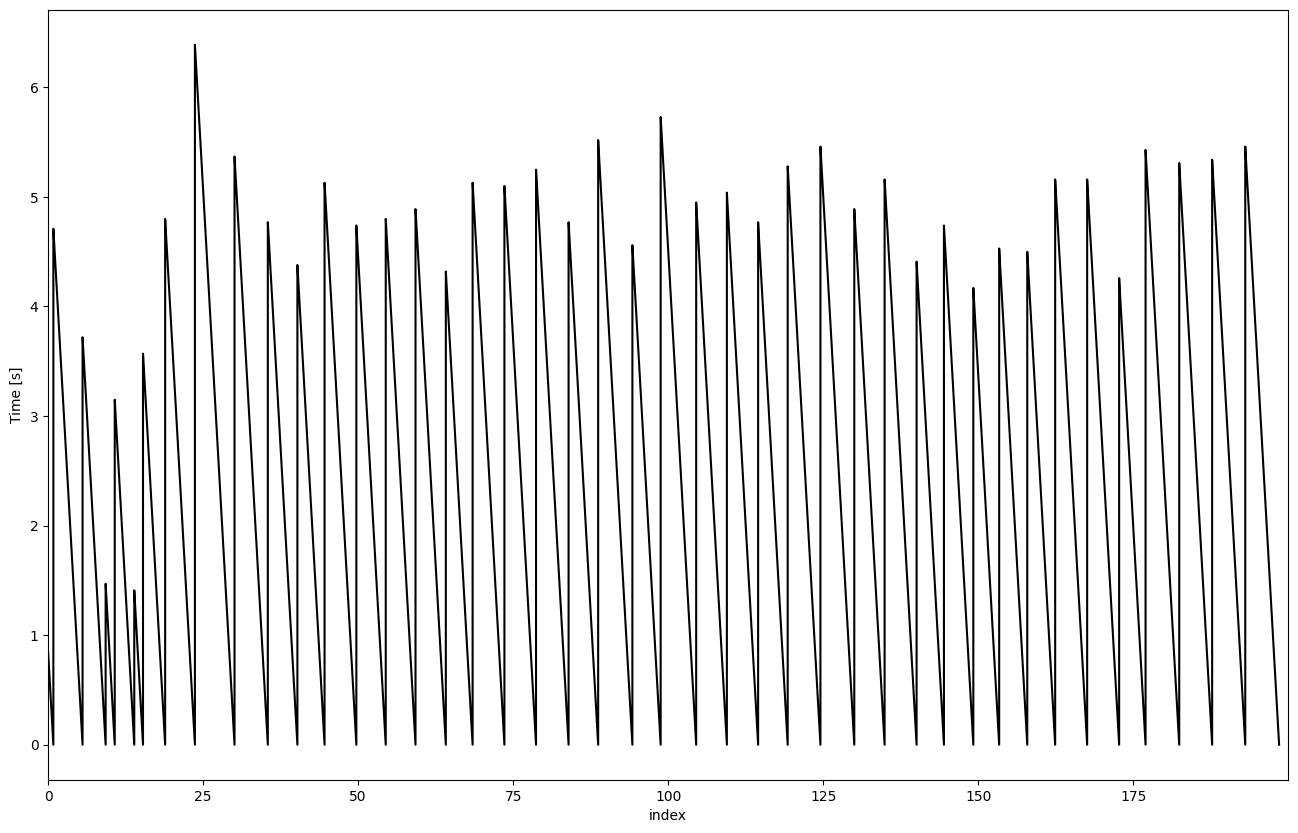

In [29]:
T = np.array(range(0, denoised_shear_stress.shape[0]))*(1/fs_red)

fig,axs = plt.subplots(1,figsize=(16,10))
axs.plot(T, TTF,color='k')
axs.set_ylabel('Time [s]')
axs.set_xlabel('index')
axs.set_xlim([T[0],T[-1]])

# Training

In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from numpy import random
import lightgbm as lgb # implementa il modello di LightGBM

random.seed(1337) # reproducibility

In [31]:
features = ['var_num_peaks_2_denoise_simple','var_percentile_roll50_std_20','var_mfcc_mean4',  'var_mfcc_mean18']

train_X = train_sample[features].values
target = train_sample["target"].values


test_X = test_sample[features].values
target_test = test_sample["target"].values

## their model

In [32]:
from sklearn.model_selection import TimeSeriesSplit

oof = np.zeros(len(train_X)) 

n_fold = 3        # 2 per training, 1 validation
                  # random_state=1337 for reproducibility
# kf = KFold(n_splits=n_fold, shuffle=True, random_state=1337)
kf = TimeSeriesSplit(n_splits=n_fold)
# kf dichiara (non agisce ancora sui dati) in quanti fold dobbiamo dividere
# il dataset. e dice come dividerli (shuffle, random state ...) 

kf = list(kf.split(np.arange(len(train_sample))))
# Il metodo split() di KFold prende in input gli indici di tutti i samples nel df di train
# Poi, sapendo quante iterazioni dobbiamo fare nell'addestramento (glielo dice KFold)
# diventa una lista con la seguente struttura (è una lista di liste):
# la dimensione più esterna è n_fold (ossia numero di iterazioni)
# dentro n_fold la lunghezza è 2 (cioè divide in indici di train e indici di valid per ogni iterazione)


In [33]:
prediction = np.zeros(len(test_X)) # prediction sul test set

In [34]:
for fold_n, (train_index, valid_index) in enumerate(tqdm(kf, desc="Training Fold")):
    print(f'Iteration: {fold_n+1}/{len(kf)}')

    trn_data = lgb.Dataset(train_X[train_index], label=target[train_index])
    val_data = lgb.Dataset(train_X[valid_index], label=target[valid_index])
    
    params = {'num_leaves': 4,
      'min_data_in_leaf': 5,
      'objective':'fair',       # è un problema di regressione. 'fair' è una funzione obiettivo simile a MAE ma più robusta agli outlier 
      'max_depth': -1,
      'learning_rate': 0.02,
      "boosting": "gbdt",
      'boost_from_average': True,
      "feature_fraction": 0.9,
      "bagging_freq": 1,
      "bagging_fraction": 0.5,
      "bagging_seed": 0,
      "metric": 'mae',
      "verbosity": -1,
      'max_bin': 500,
      'reg_alpha': 0,
      'reg_lambda': 0,
      'seed': 0,
      'n_jobs': -1 # Usa tutti i core disponibili
      }
    

    callbacks = [lgb.early_stopping(stopping_rounds=1000, verbose=True),
                 lgb.log_evaluation(period=1000)]  # Stampa i log ogni 500 iterazioni


    clf = lgb.train(params, trn_data, num_boost_round=1000000, valid_sets = [trn_data, val_data], callbacks=callbacks)

    oof[valid_index] += clf.predict(train_X[valid_index], num_iteration=clf.best_iteration)
    prediction += clf.predict(test_X, num_iteration=clf.best_iteration)

prediction /= n_fold



Training Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration: 1/3
Training until validation scores don't improve for 1000 rounds


Training Fold:  33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

[1000]	training's l1: 0.856021	valid_1's l1: 0.93812
Early stopping, best iteration is:
[384]	training's l1: 0.924629	valid_1's l1: 0.924641
Iteration: 2/3
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 0.861871	valid_1's l1: 0.922788


Training Fold:  67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]

Early stopping, best iteration is:
[411]	training's l1: 0.904151	valid_1's l1: 0.913457
Iteration: 3/3
Training until validation scores don't improve for 1000 rounds
[1000]	training's l1: 0.872497	valid_1's l1: 0.917181


Training Fold: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

Early stopping, best iteration is:
[516]	training's l1: 0.894566	valid_1's l1: 0.90787


In [35]:
print('\nMAE: ', mean_absolute_error(target, oof))


MAE:  1.2515127287560843


In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MAE
mae = mean_absolute_error(target_test, prediction)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# RMSE
rmse = mean_squared_error(target_test, prediction, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# R² Score
r2 = r2_score(target_test, prediction)
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.9627
Root Mean Squared Error (RMSE): 1.2304
R² Score: 0.3208


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


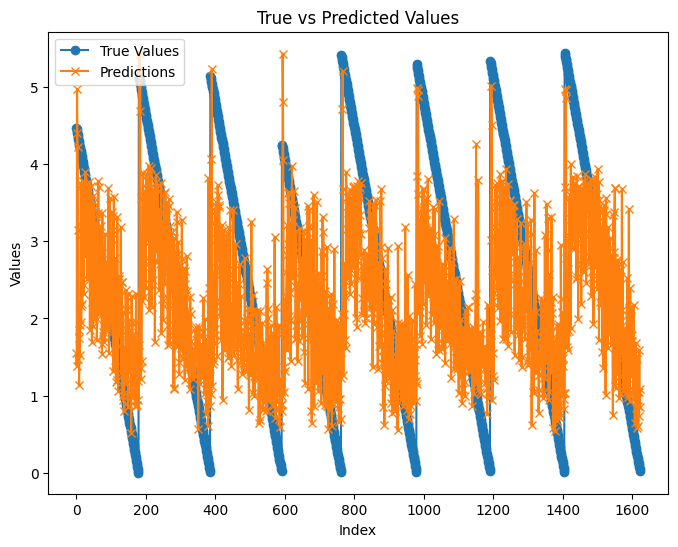

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_test, label="True Values", marker='o')
plt.plot(prediction, label="Predictions", marker='x')
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

## our model

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {
    'num_leaves': [4, 8, 16],
    'min_data_in_leaf': [5, 10, 20],
    'learning_rate': [0.01, 0.02, 0.05],
    'feature_fraction': [0.7, 0.9],
    'bagging_fraction': [0.5, 0.7],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


base_model = LGBMRegressor(
    boosting_type='gbdt',
    objective='fair',
    max_depth=-1,
    boosting='gbdt',
    bagging_freq=1,
    bagging_seed=0,
    metric='mae',
    verbosity=-1,
    max_bin=500,
    seed=0,
    n_jobs=-1
)

# KFold come prima, 3 fold, con lo stesso random_state per coerenza
n_fold = 3
kf_gs = KFold(n_splits=n_fold, shuffle=True, random_state=1337)

# GridSearchCV con le impostazioni desiderate
clf_gs = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usare MAE (negativa) come metrica di ottimizzazione
    cv=kf_gs,
    verbose=1,
    n_jobs=-1
)

# Eseguiamo la grid search sul train set
clf_gs.fit(train_X, target)

print("Migliori Parametri trovati da GridSearch:")
print(clf_gs.best_params_)

# Ora alleniamo un modello finale con i parametri ottimali su tutto il training set
best_params = clf_gs.best_params_
final_model_gs = LGBMRegressor(
    boosting_type='gbdt',
    objective='fair',
    metric='mae',
    max_depth=-1,
    boosting='gbdt',
    bagging_freq=1,
    bagging_seed=0,
    max_bin=500,
    seed=0,
    n_jobs=-1,
    **best_params  # Applichiamo i parametri ottimi trovati
)

final_model_gs.fit(train_X, target)

# Previsioni sul test set con il nuovo modello
prediction_gs = final_model_gs.predict(test_X)

print('\nMAE sul validation set: ', mean_absolute_error(target, oof))

# MAE
mae_gs = mean_absolute_error(target_test, prediction_gs)
print(f"Mean Absolute Error (MAE) con GridSearch: {mae_gs:.4f}")

# RMSE
rmse_gs = mean_squared_error(target_test, prediction_gs, squared=False)
print(f"Root Mean Squared Error (RMSE) con GridSearch: {rmse_gs:.4f}")

# R² Score
r2_gs = r2_score(target_test, prediction_gs)
print(f"R² Score con GridSearch: {r2_gs:.4f}")

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


Python(60249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60253) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(60256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Migliori Parametri trovati da GridSearch:
{'bagging_fraction': 0.5, 'feature_fraction': 0.9, 'learning_rate': 0.05, 'min_data_in_leaf': 5, 'num_leaves': 8, 'reg_alpha': 0, 'reg_lambda': 0.5}

MAE sul validation set:  1.2515127287560843
Mean Absolute Error (MAE) con GridSearch: 0.9286
Root Mean Squared Error (RMSE) con GridSearch: 1.1930
R² Score con GridSearch: 0.3614


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


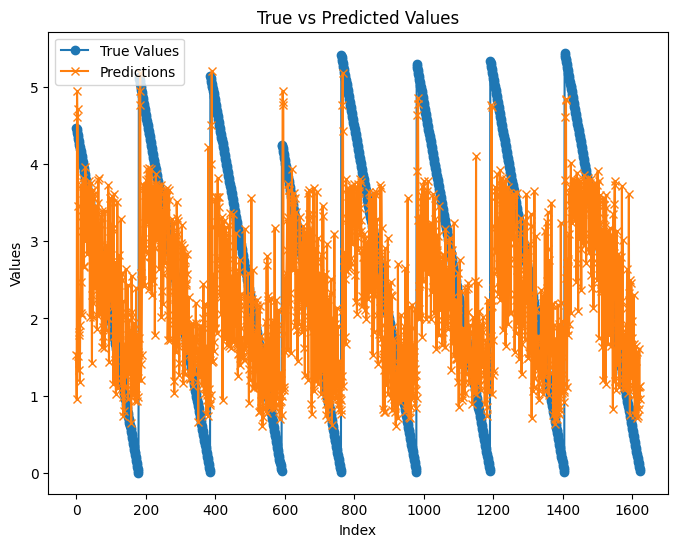

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_test, label="True Values", marker='o')
plt.plot(prediction_gs, label="Predictions", marker='x')
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

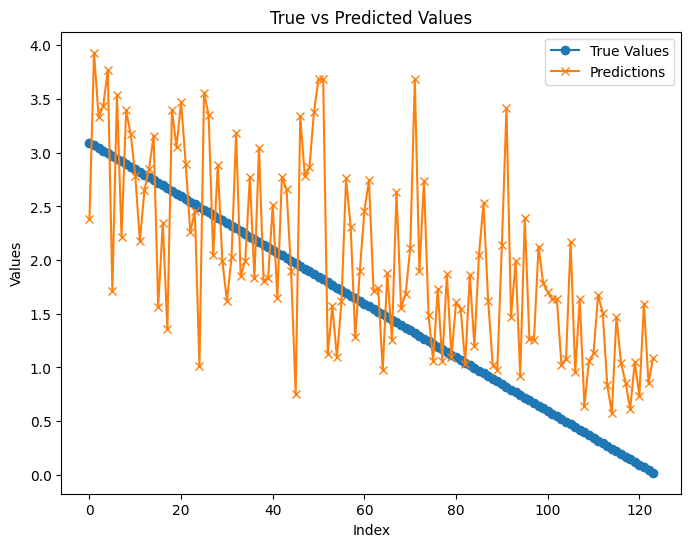

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(target_test[1500:], label="True Values", marker='o')
plt.plot(prediction[1500:], label="Predictions", marker='x')
plt.legend()
plt.title("True vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

Frazione di training: 100%
  MAE:  0.9286
  RMSE: 1.1930
  R²:   0.3614
----------------------------------------


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


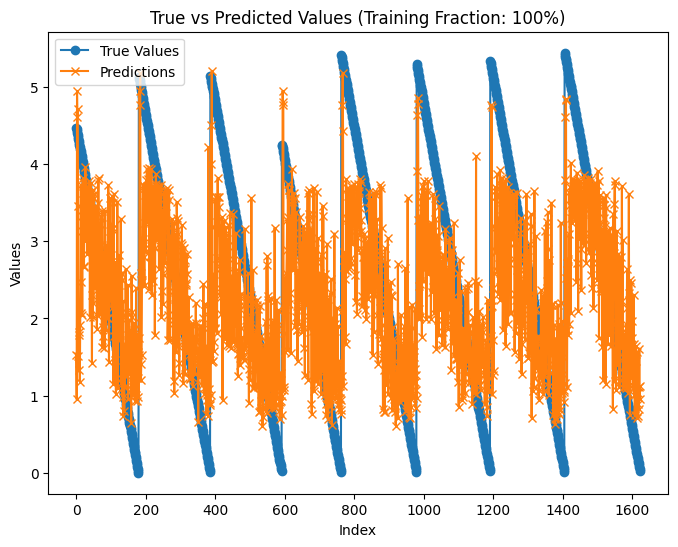

Frazione di training: 75%
  MAE:  0.9263
  RMSE: 1.1930
  R²:   0.3614
----------------------------------------


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


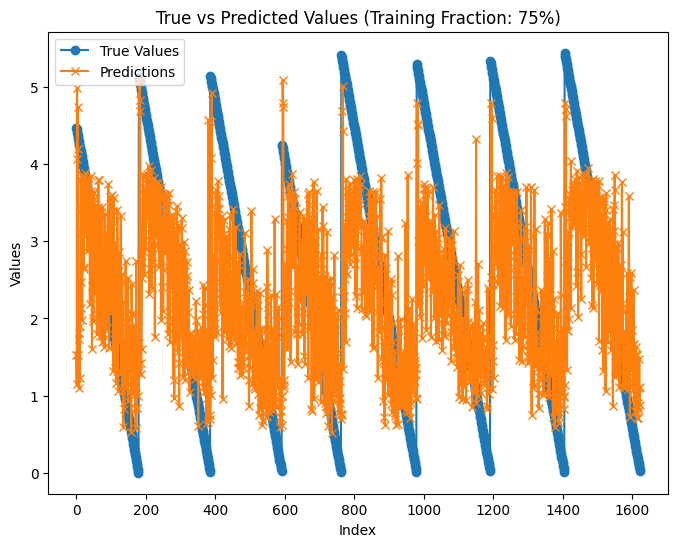

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 50%
  MAE:  0.9369
  RMSE: 1.2049
  R²:   0.3487
----------------------------------------


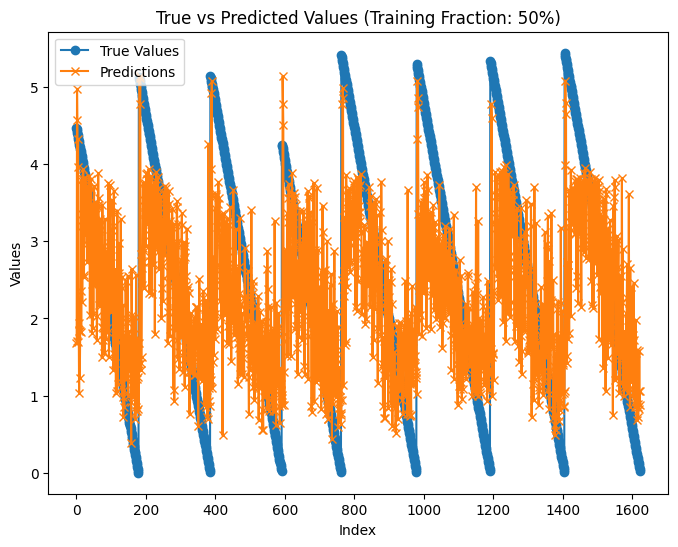

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 25%
  MAE:  0.9548
  RMSE: 1.2226
  R²:   0.3294
----------------------------------------


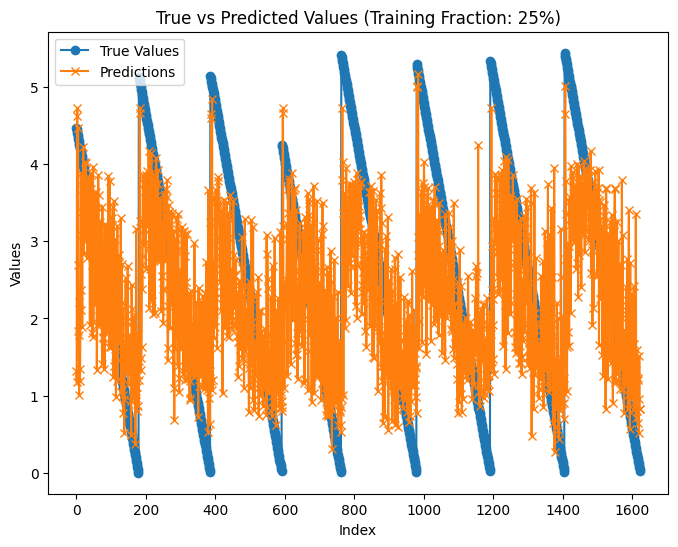

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 2%
  MAE:  1.1061
  RMSE: 1.3898
  R²:   0.1334
----------------------------------------


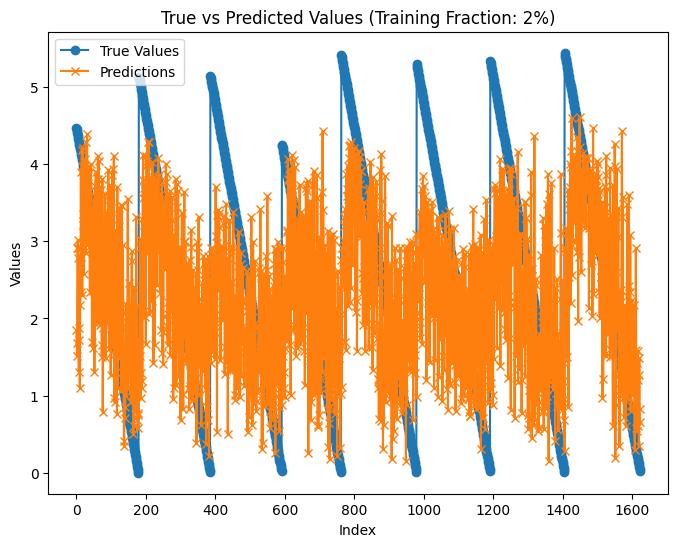

In [53]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from fractions import Fraction


# Supponiamo di avere ancora disponibili le seguenti variabili dal codice precedente:
# best_params   (i migliori parametri trovati dal GridSearch)
# train_sample, test_sample
# features
# target_test, test_X (derivanti dal test_sample)
#
# Non sovrascriviamo quindi nulla del codice precedente, 
# ma creiamo nuove variabili per questo esperimento.

# Liste o dizionari per salvare i risultati
fractions = [1.0, 0.75, 0.5, 0.25, 0.025]
mae_down_list = []
rmse_down_list = []
r2_down_list = []

# Usiamo gli stessi feature come prima
# train_sample e test_sample sono come definiti prima
# Estraiamo test_X e target_test dalle variabili già definite
# (Se già definite, non riscriviamo test_X e target_test)
# test_X = test_sample[features].values
# target_test = test_sample["target"].values
# queste variabili esistono già dal codice sopra

for frac in fractions:
    # Downsampling del train set
    # Prendiamo una frazione del train_sample
    f = Fraction(frac).limit_denominator()  # converte in frazione razionale
    num = f.numerator
    den = f.denominator

    # Selezioniamo gli indici che soddisfano la condizione:
    # "Prendi i primi num elementi di ogni blocco di den"
    indexes = [i for i in range(len(train_sample)) if i % den < num]
    train_sample_down = train_sample.iloc[indexes]
    
    # Definiamo train_X_down e target_down
    train_X_down = train_sample_down[features].values
    target_down = train_sample_down["target"].values
    
    # Creiamo un nuovo modello con gli stessi parametri ottimali
    # trovati precedentemente (best_params)
    # Non abbiamo bisogno di rifare la ricerca iperparametri
    final_model_gs_down = LGBMRegressor(
        boosting_type='gbdt',
        objective='fair',
        metric='mae',
        max_depth=-1,
        boosting='gbdt',
        bagging_freq=1,
        bagging_seed=0,
        max_bin=500,
        seed=0,
        n_jobs=-1,
        **best_params
    )
    
    # Alleniamo il modello sul dataset ridotto
    final_model_gs_down.fit(train_X_down, target_down)
    
    # Previsioni sul test
    prediction_down = final_model_gs_down.predict(test_X)
    
    # Calcoliamo le metriche e le salviamo
    mae_down = mean_absolute_error(target_test, prediction_down)
    rmse_down = mean_squared_error(target_test, prediction_down, squared=False)
    r2_down = r2_score(target_test, prediction_down)
    
    mae_down_list.append(mae_down)
    rmse_down_list.append(rmse_down)
    r2_down_list.append(r2_down)
    
    # Stampiamo i risultati per questa frazione
    print(f"Frazione di training: {frac*100:.0f}%")
    print(f"  MAE:  {mae_down:.4f}")
    print(f"  RMSE: {rmse_down:.4f}")
    print(f"  R²:   {r2_down:.4f}")
    print("-"*40)

    # Plot delle previsioni vs valori reali
    plt.figure(figsize=(8, 6))
    plt.plot(target_test, label="True Values", marker='o')
    plt.plot(prediction_down, label="Predictions", marker='x')
    plt.legend()
    plt.title(f"True vs Predicted Values (Training Fraction: {frac*100:.0f}%)")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.show()

# In questo modo abbiamo allenato e valutato un nuovo modello per ogni frazione, 
# senza sovrascrivere le variabili precedenti.
# Le metriche sono salvate in mae_down_list, rmse_down_list, r2_down_list e 
# possono essere utilizzate per un confronto successivo.

Frazione di training: 100%
  MAE:  0.9286
  RMSE: 1.1930
  R²:   0.3614
----------------------------------------


/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


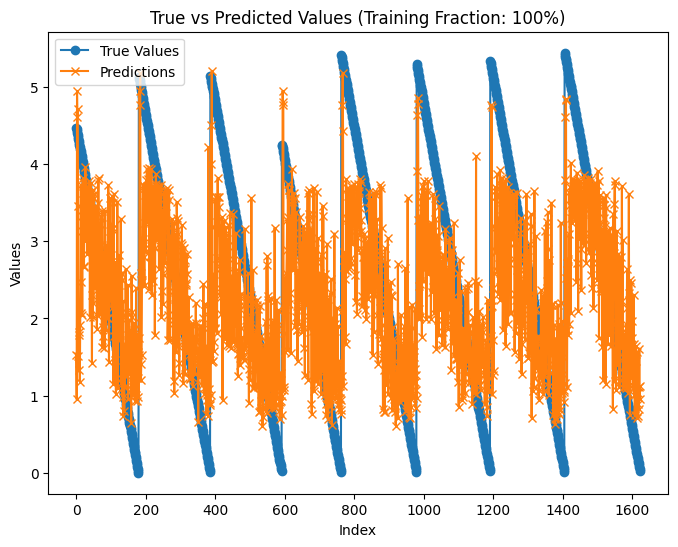

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 80%
  MAE:  0.9395
  RMSE: 1.2103
  R²:   0.3428
----------------------------------------


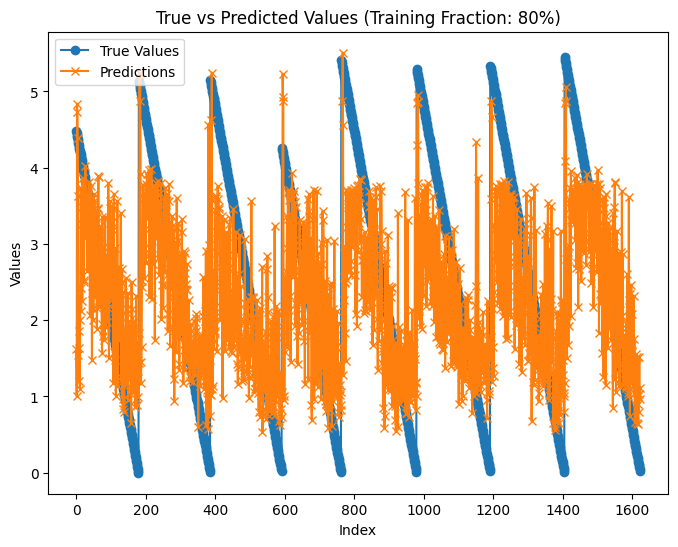

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 60%
  MAE:  0.9599
  RMSE: 1.2269
  R²:   0.3247
----------------------------------------


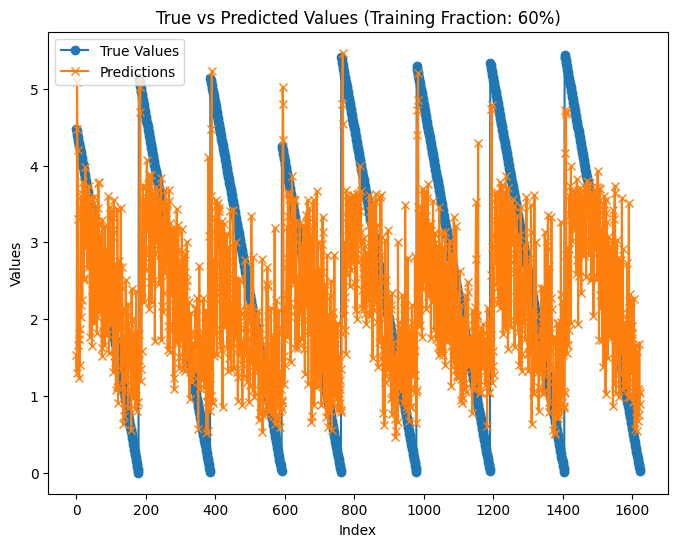

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 50%
  MAE:  0.9723
  RMSE: 1.2410
  R²:   0.3090
----------------------------------------


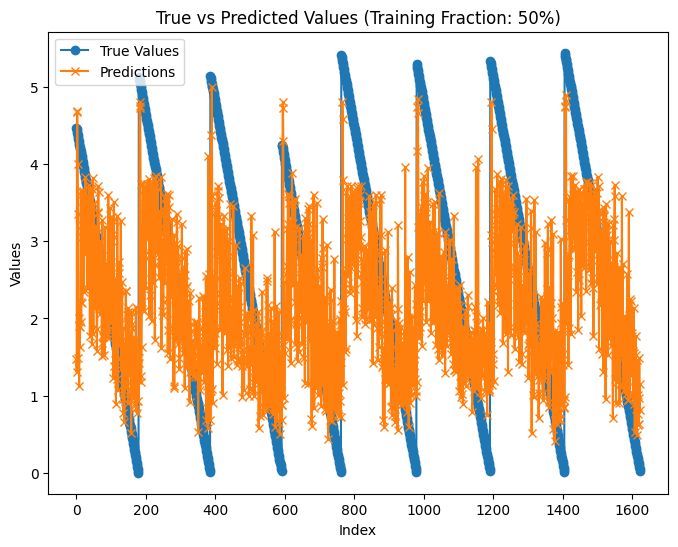

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 25%
  MAE:  1.0083
  RMSE: 1.2837
  R²:   0.2607
----------------------------------------


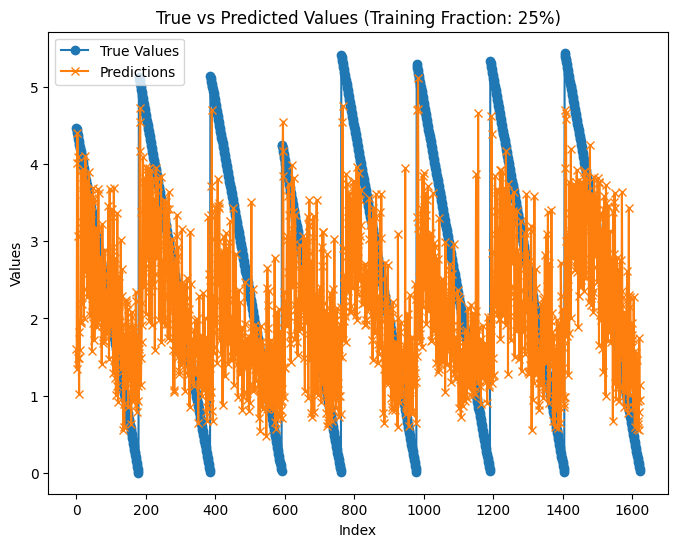

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 10%
  MAE:  1.2461
  RMSE: 1.5719
  R²:   -0.1085
----------------------------------------


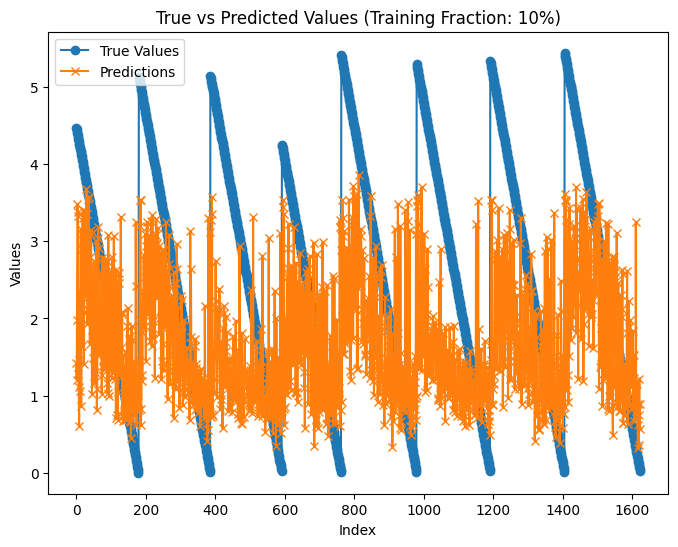

/Users/andreagentilini/Desktop/Progetto_Chris/Coding_Chris/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Frazione di training: 5%
  MAE:  1.1396
  RMSE: 1.4105
  R²:   0.1073
----------------------------------------


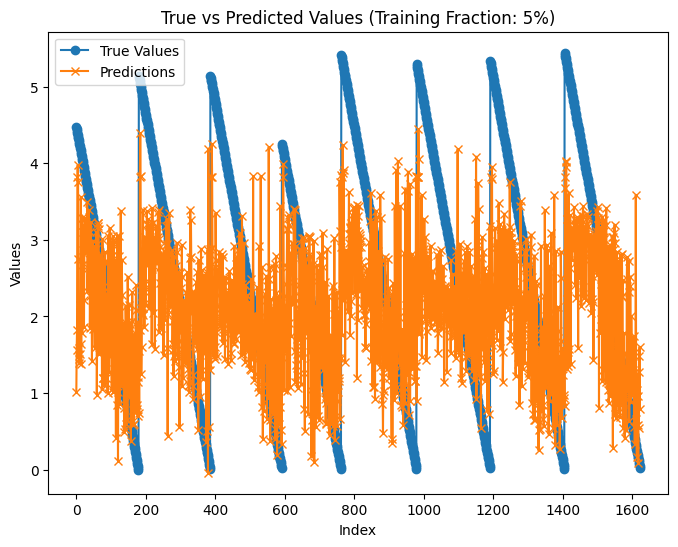

In [52]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from fractions import Fraction


# Supponiamo di avere ancora disponibili le seguenti variabili dal codice precedente:
# best_params   (i migliori parametri trovati dal GridSearch)
# train_sample, test_sample
# features
# target_test, test_X (derivanti dal test_sample)
#
# Non sovrascriviamo quindi nulla del codice precedente, 
# ma creiamo nuove variabili per questo esperimento.

# Liste o dizionari per salvare i risultati
fractions = [1.0, 0.8, 0.6, 0.5, 0.25, 0.10, 0.05]
mae_down_list = []
rmse_down_list = []
r2_down_list = []

# Usiamo gli stessi feature come prima
# train_sample e test_sample sono come definiti prima
# Estraiamo test_X e target_test dalle variabili già definite
# (Se già definite, non riscriviamo test_X e target_test)
# test_X = test_sample[features].values
# target_test = test_sample["target"].values
# queste variabili esistono già dal codice sopra

for frac in fractions:
    # Downsampling del train set
    # Prendiamo una frazione del train_sample
    n_rows = int(len(train_sample) * frac)
    train_sample_down = train_sample.iloc[:n_rows]
    
    # Definiamo train_X_down e target_down
    train_X_down = train_sample_down[features].values
    target_down = train_sample_down["target"].values
    
    # Creiamo un nuovo modello con gli stessi parametri ottimali
    # trovati precedentemente (best_params)
    # Non abbiamo bisogno di rifare la ricerca iperparametri
    final_model_gs_down = LGBMRegressor(
        boosting_type='gbdt',
        objective='fair',
        metric='mae',
        max_depth=-1,
        boosting='gbdt',
        bagging_freq=1,
        bagging_seed=0,
        max_bin=500,
        seed=0,
        n_jobs=-1,
        **best_params
    )
    
    # Alleniamo il modello sul dataset ridotto
    final_model_gs_down.fit(train_X_down, target_down)
    
    # Previsioni sul test
    prediction_down = final_model_gs_down.predict(test_X)
    
    # Calcoliamo le metriche e le salviamo
    mae_down = mean_absolute_error(target_test, prediction_down)
    rmse_down = mean_squared_error(target_test, prediction_down, squared=False)
    r2_down = r2_score(target_test, prediction_down)
    
    mae_down_list.append(mae_down)
    rmse_down_list.append(rmse_down)
    r2_down_list.append(r2_down)
    
    # Stampiamo i risultati per questa frazione
    print(f"Frazione di training: {frac*100:.0f}%")
    print(f"  MAE:  {mae_down:.4f}")
    print(f"  RMSE: {rmse_down:.4f}")
    print(f"  R²:   {r2_down:.4f}")
    print("-"*40)

    # Plot delle previsioni vs valori reali
    plt.figure(figsize=(8, 6))
    plt.plot(target_test, label="True Values", marker='o')
    plt.plot(prediction_down, label="Predictions", marker='x')
    plt.legend()
    plt.title(f"True vs Predicted Values (Training Fraction: {frac*100:.0f}%)")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.show()

# In questo modo abbiamo allenato e valutato un nuovo modello per ogni frazione, 
# senza sovrascrivere le variabili precedenti.
# Le metriche sono salvate in mae_down_list, rmse_down_list, r2_down_list e 
# possono essere utilizzate per un confronto successivo.